In [52]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline


In [53]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
!ls /content/drive/MyDrive/names.txt

/content/drive/MyDrive/names.txt


In [55]:
# read in all the words
words = open('/content/drive/MyDrive/names.txt', "r" , ).read().splitlines()

In [56]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [57]:
len(words)

32033

In [58]:
#build vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = { i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [59]:
#build the dataset

block_size = 3 #context length:how many characters do we take

X,Y = [] , []

for w in words:

  #print(w)
  context = [0] * block_size

  for ch in w +'.':

    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '---->' , itos[ix])
    context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [60]:
#build the dataset

def build_dataset(words):

    block_size = 3 #context length:how many characters do we take

    X,Y = [] , []

    for w in words:

      #print(w)
      context = [0] * block_size

      for ch in w +'.':

        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->' , itos[ix])
        context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape , Y.shape )
    return X , Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr , Ytr = build_dataset(words[:n1])
Xdev , Ydev = build_dataset(words[n1:n2])
Xte , Yte = build_dataset(words[n2:])



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [61]:
# --------- make it more respectable -----------

In [62]:
Xtr.shape , Xtr.dtype , Ytr.shape , Ytr.dtype

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [63]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27 , 10) , generator = g)
W1 = torch.randn((30 , 200) , generator = g)
b1 = torch.randn(200 , generator = g)
W2 = torch.randn((200 , 27) , generator = g)
b2 = torch.randn(27 , generator = g)
parameters = [C , W1 , b1 , W2 , b2]

In [64]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [65]:
for p in parameters:
  p.requires_grad = True

In [66]:
lre = torch.linspace(-3 , 0 , 1000)
lrs = 10 ** lre

In [67]:
lri = []
lossi = []
stepi = []

In [74]:
for i in range(300000):

    # mini - batch
    ix = torch.randint(0 , Xtr.shape[0] , (32 , ))
    #forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1 , 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits , Ytr[ix])


    #backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

    #update
    lr = 0.005
    for p in parameters:
      p.data += -lr * p.grad

    #tracking
    # lri.append(lre[i])
    stepi.append(i)

    lossi.append(loss.log().item())

print(loss.item())

2.154757499694824


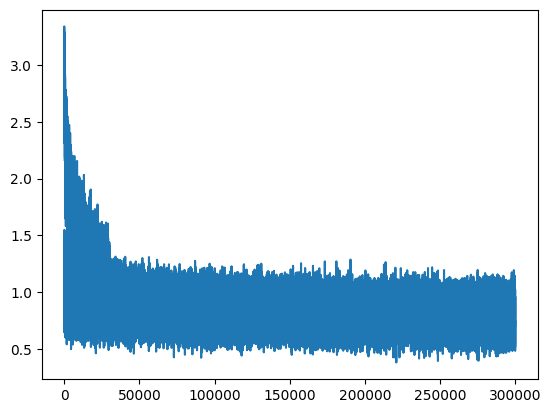

In [75]:
plt.plot(stepi , lossi)

In [76]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1 , 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits , Ytr)
loss

tensor(2.2688, grad_fn=<NllLossBackward0>)

In [77]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1 , 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits , Ydev)
loss

tensor(2.2756, grad_fn=<NllLossBackward0>)

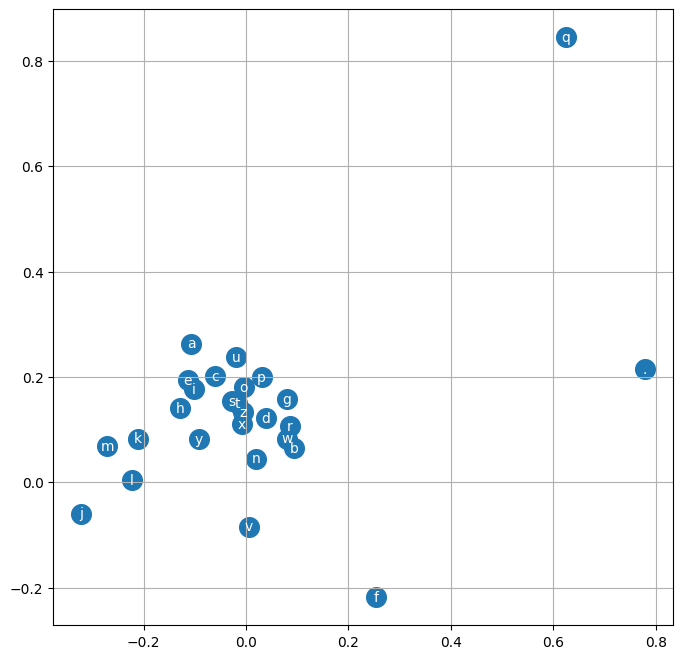

In [78]:
plt.figure(figsize = (8 , 8))
plt.scatter(C[: ,0].data , C[: ,1].data , s = 200)

for i in range(27):
  plt.text(C[i , 0].item() , C[i , 1].item() , itos[i] , ha = "center" , va = "center" , color = "white")
plt.grid('minor')

In [79]:
#sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size

  while True:
    emb  = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1 , -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits , dim = 1)
    ix = torch.multinomial(probs , num_samples = 1 , replacement = True , generator = g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))



mora.
kayah.
seel.
nihah.
larethan.
brdra.
gra.
ched.
eliighay.
jelle.
elieananar.
kayzion.
kamin.
shdbergahiriel.
kin.
renelinnn.
puor.
ubelleda.
kylynn.
ehs.
